In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import os
if os.path.basename(os.getcwd()) != 'food-pairing':
    os.chdir(os.path.dirname(os.getcwd()))

from utils.data_loading import read_food_molecules
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
def pad_lists(lst, max_len: int = 10):
    out = [0] * max_len
    if len(lst) == max_len:
        lst = [*map(int, lst)]
        return np.asarray(lst)
    elif len(lst) < max_len:
        out[:len(lst)] = lst
        out = [*map(int, out)]
        return np.asarray(out)
    else:
        lst = [*map(int, lst)]
        return np.asarray(lst[:max_len])

In [92]:
def find_n_neighbours(df, model, target_id, n_neighbors=10):
    target_id_vec = df.loc[df['id'] == target_id, 'molecules']
    if len(target_id_vec) == 0: 
        return [0], [0]
    target_id_vec = target_id_vec.values.tolist()
    distances, indices = model.kneighbors(
        target_id_vec,
        n_neighbors=n_neighbors+1)
    indices = indices.squeeze().tolist()
    for index in indices:
        index = (df.iloc[index])['id']
        # indices[i] = (df.index.to_list())[indices[i]]
    raw_recommends = \
        sorted(
            list(
                zip(
                    indices,
                    distances.squeeze().tolist()
                )
            ),
            key=lambda x: x[1]
        )[:0:-1]

    sorted_indices = [x[0] for x in raw_recommends]

    return raw_recommends, sorted_indices


In [61]:
flavor_df = read_food_molecules()

flavor_df['molecules'] = flavor_df['molecules'].apply(lambda x: pad_lists(x))

In [62]:
knn = NearestNeighbors(metric='manhattan', n_neighbors=10, n_jobs=-1)

y = flavor_df['molecules'].values
x = flavor_df['food_id'].values

# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

knn.fit(y.tolist())

NearestNeighbors(metric='manhattan', n_jobs=-1, n_neighbors=10)

In [94]:
entity = 'apple'
entity_id = flavor_df.loc[flavor_df['food'] == entity, 'id']

raw_recommends, sorted_indices = find_n_neighbours(flavor_df, knn, int(entity_id.iloc[0]))

In [95]:
reccomends = [str((flavor_df.loc[flavor_df['food_id'] == x, 'food']).iloc[0]) for x in sorted_indices]

In [96]:
reccomends

['peanut oil',
 'winter savory',
 'radish',
 'rambutan',
 'ricotta cheese',
 'wild cherry',
 'scotch spearmint',
 'redskin onion',
 'mustard',
 'orange']

In [16]:
y = np.stack(y.tolist(), axis=0)

In [17]:
from sklearn.manifold import TSNE

n_iter = 500
perplexity = 30
metric = "euclidean"
# TSNE requires a certain number of neighbors which depends on the
# perplexity parameter.
# Add one since we include each sample as its own neighbor.
n_neighbors = int(3.0 * perplexity + 1) + 1

tsne_params = dict(
    init="random",  # pca not supported for sparse matrices
    perplexity=perplexity,
    method="barnes_hut",
    random_state=42,
    n_iter=n_iter,
    learning_rate="auto",
)

flavor_emb = TSNE(metric="euclidean", **tsne_params).fit_transform(y)

In [18]:
print((flavor_emb).shape)

(812, 2)


In [20]:
fig = px.scatter(
    flavor_emb, x=0, y=1,
    text=flavor_df['food']
)
fig.update_traces(textposition='top center')

fig.update_layout(  
    height=800,
    title_text='Flavor t-SNE'
)
fig.show()

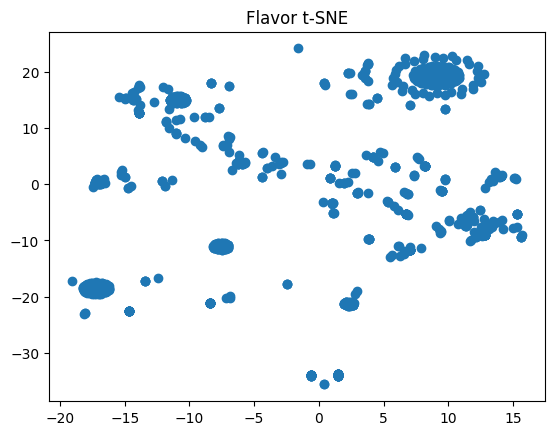

In [21]:
fig, ax = plt.subplots()

ax.set_title("Flavor t-SNE")
ax.scatter(
    flavor_emb[:, 0],
    flavor_emb[:, 1],
    #c=y.astype(np.int32),
    #alpha=0.2,
    #cmap=plt.cm.viridis,
)
plt.show()

## FooDB test
___

In [28]:
foodb_df = read_food_molecules('foodb')

foodb_df['molecules'] = foodb_df['molecules'].apply(lambda x: pad_lists(x, max_len=20))

In [29]:
knn = NearestNeighbors(metric='manhattan', n_neighbors=10, n_jobs=-1)

y = foodb_df['molecules'].values
x = foodb_df['food_id'].values

# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

knn.fit(y.tolist())

NearestNeighbors(metric='manhattan', n_jobs=-1, n_neighbors=10)

In [30]:
def find_n_neighbours(df, model, target_id, n_neighbors=10):
    target_id_vec = df.loc[df['food_id'] == target_id, 'molecules']

    if len(target_id_vec) == 0: 
        return [0], [0]
    
    target_id_vec = target_id_vec.values.tolist()
    distances, indices = model.kneighbors(
        target_id_vec,
        n_neighbors=n_neighbors+1)

    indices = indices.squeeze().tolist()
    print(indices)
    for index in indices:
        index = (df.iloc[index])['food_id']
        # indices[i] = (df.index.to_list())[indices[i]]
    print(indices)
    raw_recommends = \
        sorted(
            list(
                zip(
                    indices,
                    distances.squeeze().tolist()
                )
            ),
            key=lambda x: x[1]
        )[:0:-1]

    sorted_indices = [x[0] for x in raw_recommends]

    return raw_recommends, sorted_indices


In [11]:
entity_id

4

In [31]:
entity = 'Apple'
entity_id = foodb_df.loc[foodb_df['food'] == entity, 'food_id'].iloc[0]

_, sorted_indices = find_n_neighbours(foodb_df, knn, entity_id)

# reccomends = [str((foodb_df.loc[foodb_df['id'] == x, 'ingredient']).iloc[0]) for x in sorted_indices]

[36, 510, 223, 872, 853, 2, 538, 413, 459, 588, 558]
[36, 510, 223, 872, 853, 2, 538, 413, 459, 588, 558]


In [39]:
reccomends = [str((foodb_df.iloc[x])['food']) for x in sorted_indices]

In [38]:
(foodb_df.iloc[510])['food']

'Malus (Crab apple)'

In [40]:
reccomends

['Mustard',
 'Okra',
 'Kale',
 'Hazelnut',
 'Miso',
 'Acerola',
 'Stuffing',
 'Sweet potato',
 'Common beet',
 'Malus (Crab apple)']

In [34]:
y = np.stack(y.tolist(), axis=0)

n_iter = 500
perplexity = 30
metric = "euclidean"
# TSNE requires a certain number of neighbors which depends on the
# perplexity parameter.
# Add one since we include each sample as its own neighbor.
n_neighbors = int(3.0 * perplexity + 1) + 1

tsne_params = dict(
    init="random",  # pca not supported for sparse matrices
    perplexity=perplexity,
    method="barnes_hut",
    random_state=42,
    n_iter=n_iter,
    learning_rate="auto",
)

flavor_emb = TSNE(metric="euclidean", **tsne_params).fit_transform(y)

In [35]:
fig = px.scatter(
    flavor_emb, x=0, y=1,
    text=foodb_df['food']
)
fig.update_traces(textposition='top center')

fig.update_layout(  
    height=800,
    title_text='Flavor t-SNE'
)
fig.show()